In [ ]:
import typing

import torch
from torch import nn

import collections
import typing

import numpy as np

In [ ]:
QNetwork = nn.Module

In [ ]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)

In [ ]:
def make_deep_q_network_fn(action_size: int) -> typing.Callable[[], QNetwork]:
    
    def deep_q_network_fn() -> QNetwork:
        q_network = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
            nn.ReLU(),
            LambdaLayer(lambda tensor: tensor.view(tensor.size(0), -1)),
            nn.Linear(in_features=25024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=action_size)
        )
        return q_network
    
    return deep_q_network_fn

In [ ]:
_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.
        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return len(self._buffer)
    
    @property
    def batch_size(self) -> int:
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def is_full(self) -> bool:
        return len(self._buffer) == self._buffer_size
    
    def append(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        self._buffer.append(experience)
    
    def sample(self) -> typing.List[Experience]:
        """Randomly sample a batch of experiences from memory."""
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Using cached https://files.pythonhosted.org/packages/69/ec/8221a07850d69fa3c57c02e526edd23d18c7c05d58ed103e3b19172757c1/PyVirtualDisplay-0.2.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a2/3c/f42a62b7784c04b20f8b88d6c8ad04f4f20b0767b721102418aad94d8389/PyOpenGL-accelerate-3.1.5.tar.gz
  Using cached https://files.pythonhosted.org/packages/06/bd/6cdc3fd994b0649dcf5d9bad85bd9e26172308bbe9a421bfc6fdbf5081a6/box2d_py-2.3.8-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/48/3c/75573613641c90c6d094059ac28adb748560d99bd27ee6f80cce398f404e/EasyProcess-0.3-py2.py3-none-any.whl
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp36-cp36m-linu

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import gym

env = gym.make('LunarLander-v2')
_ = env.seed(42)

In [ ]:
class Agent:
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


In [ ]:
def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

                
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timsteps (int): maximum number of timesteps per episode.
    
    Returns:
    --------
    scores (list): collection of episode scores from training.
    
    """
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores

In [ ]:
from torch import optim
from torch.nn import functional as F


class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[torch.nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        number_hidden_units (int): number of units in the hidden layers.
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        batch_size (int): number of experience tuples in each mini-batch.
        buffer_size (int): maximum number of experience tuples stored in the replay buffer.
        epsilon_decay_schdule (callable): function that takes episode number and returns epsilon.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        seed (int): random seed
        
        """
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        self._experience_replay_buffer = ExperienceReplayBuffer(batch_size, buffer_size, seed)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._local_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        self._synchronize_q_networks()
        
        # send the networks to the device
        self._local_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._local_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        self._number_parameter_updates = 0
        
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network for approximating the action-value function."""
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network
        
    def _learn_from(self, experiences: typing.List[Experience]) -> None:
        """Heart of the Deep Q-learning algorithm."""
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        # get max predicted Q values (for next states) from target model
        next_target_q_values, _ = (self._target_q_network(next_states)
                                       .detach()
                                       .max(dim=1))
        
        # compute the new Q' values using the Q-learning formula
        target_q_values = rewards + (self._gamma * next_target_q_values * (1 - dones))
        
        # get expected Q values from local model
        _index = (actions.long()
                         .unsqueeze(dim=1))
        expected_q_values = (self._local_q_network(states)
                                 .gather(dim=1, index=_index))
        # compute the mean squared loss
        loss = F.mse_loss(expected_q_values, target_q_values.unsqueeze(dim=1))
        
        # agent updates the parameters theta of Q using gradient descent
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        self._soft_update_target_q_network_parameters()
                 
    def _soft_update_target_q_network_parameters(self) -> None:
        """Soft-update of target q-network parameters with the local q-network parameters."""
        for target_param, local_param in zip(self._target_q_network.parameters(), self._local_q_network.parameters()):
            target_param.data.copy_(self._alpha * local_param.data + (1 - self._alpha) * target_param.data)
    
    def _synchronize_q_networks(self) -> None:
        """Synchronize the target_q_network and the local_q_network."""
        _ = self._target_q_network.load_state_dict(self._local_q_network.state_dict())
           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        # evaluate the network to compute the action values
        self._local_q_network.eval()
        with torch.no_grad():
            action_values = self._local_q_network(state)
        self._local_q_network.train()
        
        # choose the greedy action
        action = (action_values.cpu()  # action_values might reside on the GPU!
                               .argmax()
                               .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.
        
        Parameters:
        -----------
        state (np.array): current state of the environment.
        
        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._experience_replay_buffer) >= self._experience_replay_buffer.batch_size
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q-network-state": self._local_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._experience_replay_buffer.batch_size,
                "buffer_size": self._experience_replay_buffer.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        # save experience in the experience replay buffer
        experience = Experience(state, action, reward, next_state, done)
        self._experience_replay_buffer.append(experience)
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._experience_replay_buffer.sample()
                self._learn_from(experiences)


In [ ]:
def linear_decay_schedule(episode_number: int,
                          slope: float,
                          minimum_epsilon: float) -> float:
    """Simple linear decay schedule used in the Deepmind paper."""
    return max(1 - slope * episode_number, minimum_epsilon)

def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.995,
    "minimum_epsilon": 1e-2,
}

epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

In [ ]:
_optimizer_kwargs = {
    "lr": 1e-2,
    "alpha": 0.99,
    "eps": 1e-08,
    "weight_decay": 0,
    "momentum": 0,
    "centered": False
}
optimizer_fn = lambda parameters: optim.RMSprop(parameters, **_optimizer_kwargs)

In [ ]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
deep_q_agent = DeepQAgent(**_agent_kwargs)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

import time
def simulate(agent: Agent, env: gym.Env, ax: plt.Axes) -> None:
    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent.choose_action(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action) 
        time.sleep(0.0001)      
    env.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


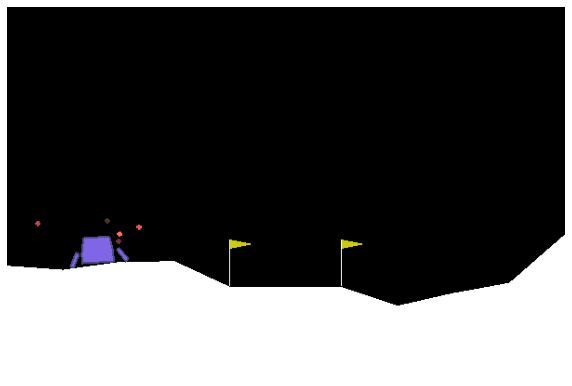

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
simulate(deep_q_agent, env, ax)

In [ ]:
scores = train(deep_q_agent, env, "checkpoint.pth", number_episodes=20000, target_score=200)


Episode 100	Average Score: -157.26
Episode 200	Average Score: -119.58
Episode 300	Average Score: -36.08
Episode 400	Average Score: 14.90
Episode 500	Average Score: 26.12
Episode 600	Average Score: 124.47
Episode 700	Average Score: 158.64
Episode 800	Average Score: 103.27
Episode 900	Average Score: 121.05
Episode 1000	Average Score: 161.00
Episode 1100	Average Score: 170.20
Episode 1200	Average Score: 154.55
Episode 1300	Average Score: 124.06
Episode 1400	Average Score: 140.04
Episode 1500	Average Score: 175.32
Episode 1600	Average Score: 178.33
Episode 1700	Average Score: 99.03
Episode 1800	Average Score: 158.21
Episode 1900	Average Score: 184.69

Environment solved in 1997 episodes!	Average Score: 202.15


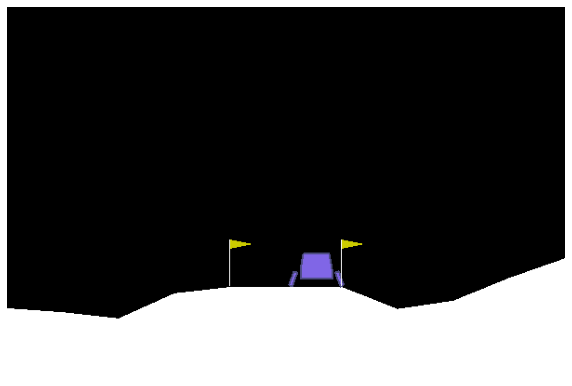

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
simulate(deep_q_agent, env, ax)

In [ ]:
import pandas as pd 
scores = pd.Series(scores, name="scores")
scores.describe()

count    1998.000000
mean       99.123340
std       174.896602
min      -734.927875
25%       -36.809788
50%       183.024484
75%       249.454729
max       313.489185
Name: scores, dtype: float64

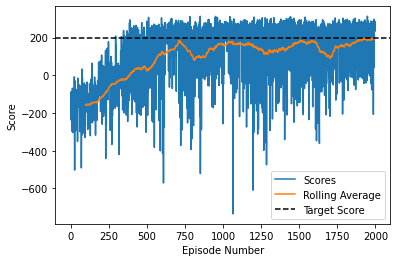

In [ ]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.axhline(200, color='k', linestyle="dashed", label="Target Score")
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")


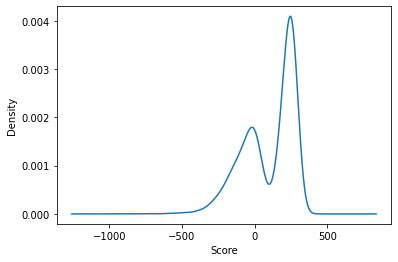

In [ ]:
fig, ax = plt.subplots(1,1)
_ = scores.plot(kind="kde", ax=ax)
_ = ax.set_xlabel("Score")

In [ ]:
deep_q_agent.save('deep_q_agent.model')